In [1]:
from nltk.tokenize.casual import TweetTokenizer
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


Load words embeddings (FastText trained over VK posts)

In [2]:
fasttext = KeyedVectors.load_word2vec_format('embeddings/fasttext_big_300d.vec')
fasttext.most_similar('котейка')

[('котейко', 0.7458697557449341),
 ('Котейка', 0.7427492141723633),
 ('котейки', 0.6791476011276245),
 ('котейкой', 0.6727944612503052),
 ('кошак', 0.6622782945632935),
 ('котэ', 0.6595468521118164),
 ('совушка', 0.658632755279541),
 ('киса', 0.642015278339386),
 ('котейку', 0.633861243724823),
 ('собакадругчеловека', 0.6230987310409546)]

In [3]:
fasttext.most_similar('cat')

[('cats', 0.8391395211219788),
 ('kitten', 0.8023779988288879),
 ('dog', 0.7982020378112793),
 ('kittens', 0.7829532623291016),
 ('pet', 0.7627919912338257),
 ('kitty', 0.7567681074142456),
 ('catsagram', 0.7563411593437195),
 ('catstagram', 0.75223708152771),
 ('petstagram', 0.7464101314544678),
 ('catsofinstagram', 0.7379685640335083)]

Load preprocessed data

In [4]:
df = pd.read_csv('data/preprocessed.csv')
df.head()

,Unnamed: 0,preprocessed_text,sentiment
0,0,встретилась с лучшим другом мы не виделись 10 ...,1
1,1,спать хотела :d да и приболела немного тебе с...,1
2,2,да:((( глупо надеяться что вернут да?,0
3,3,бабушка валя сегодня достала нереально рот не ...,0
4,4,рекомендую вот этих товарищей это на первое в...,1


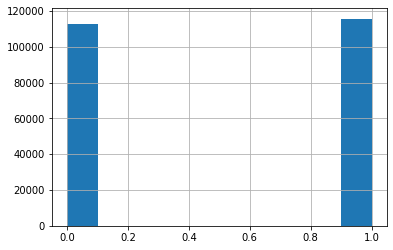

In [5]:
df['sentiment'].hist()

In [6]:
df['sentiment'].value_counts()

1    115663
0    112674
Name: sentiment, dtype: int64

Data is pretty balanced and we don't have any class preferences

Train/test split

In [7]:
data_train, data_test, label_train, label_test = train_test_split(
    df['preprocessed_text'],
    df['sentiment'],
    test_size=0.3,
    shuffle=True,
    random_state=42
)

Load tweet tokenizer

In [8]:
tweet_tokenizer = TweetTokenizer()

Prepare data for BiLSTM

In [9]:
def text_data_to_tokens(texts):
    res = []
    for txt in texts:
        tokenized_txt = tweet_tokenizer.tokenize(txt)
        replaced_by_num = [fasttext.vocab[word].index for word in tokenized_txt if word in fasttext.vocab]
        res.append(replaced_by_num)
    return res

In [10]:
X_train_bilstm = text_data_to_tokens(data_train)
X_test_bilstm = text_data_to_tokens(data_test)
len(X_train_bilstm), len(X_test_bilstm)

(159835, 68502)

The longest sentence length

In [11]:
max([max([len(x) for x in X_train_bilstm]), max([len(x) for x in X_test_bilstm])])

497

Embedding layer params

In [12]:
fasttext.get_keras_embedding().get_config()

{'name': 'embedding_1',
 'trainable': False,
 'batch_input_shape': (None, None),
 'dtype': 'float32',
 'input_dim': 507470,
 'output_dim': 300,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': False,
 'input_length': None}

Metrics definition

In [13]:
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

BiLSTM training

In [14]:
maxlen = 500
batch_size = 256
epochs = 10

X_train = sequence.pad_sequences(X_train_bilstm, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test_bilstm, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(label_train)
y_test = np.array(label_test)

model = Sequential()
model.add(fasttext.get_keras_embedding())
model.add(Bidirectional(LSTM(150)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

callbacks = [ModelCheckpoint(filepath='trained_models/fasttext_bilstm.h5', 
                             monitor='val_f1', 
                             save_best_only=True)
            ]
model.compile('adadelta', 'binary_crossentropy', metrics=[precision, recall, f1])

X_train shape: (159835, 500)
X_test shape: (68502, 500)









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         152241000 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300)               541200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 152,782,501
Trainable params: 541,501
Non-trainable params: 152,241,000
_________________________________________________________________


In [16]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=0.15, 
                    callbacks=callbacks)



Train on 135859 samples, validate on 23976 samples
Epoch 1/10
135859/135859 [==============================] - 777s 6ms/step - loss: 0.3168 - precision: 0.8442 - recall: 0.8646 - f1: 0.8476 - val_loss: 0.2547 - val_precision: 0.8890 - val_recall: 0.8591 - val_f1: 0.8734
Epoch 2/10
135859/135859 [==============================] - 763s 6ms/step - loss: 0.2486 - precision: 0.8744 - recall: 0.8824 - f1: 0.8769 - val_loss: 0.2496 - val_precision: 0.8311 - val_recall: 0.9427 - val_f1: 0.8830
Epoch 3/10
135859/135859 [==============================] - 762s 6ms/step - loss: 0.2314 - precision: 0.8837 - recall: 0.8868 - f1: 0.8839 - val_loss: 0.2223 - val_precision: 0.8736 - val_recall: 0.9029 - val_f1: 0.8875
Epoch 4/10
135859/135859 [==============================] - 763s 6ms/step - loss: 0.2253 - precision: 0.8889 - recall: 0.8904 - f1: 0.8884 - val_loss: 0.2163 - val_precision: 0.8791 - val_recall: 0.9018 - val_f1: 0.8898
Epoch 5/10
135859/135859 [==============================] - 760s 6m

Some plots

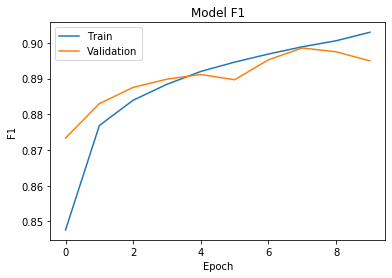

In [22]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

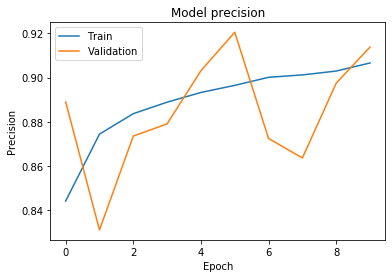

In [23]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

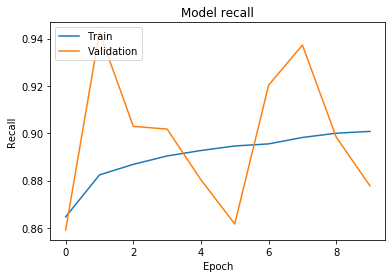

In [24]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

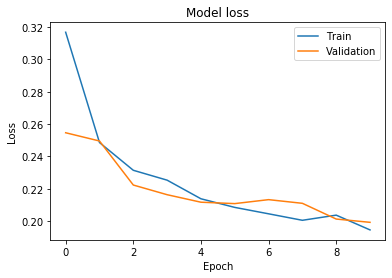

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Test classification report

In [26]:
start = time.time()
print(classification_report(y_test, model.predict_classes(X_test)))
end = time.time()
print('Inference on {} sentences took {} seconds'.format(len(X_test), end - start))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90     33579
           1       0.91      0.88      0.90     34923

    accuracy                           0.90     68502
   macro avg       0.90      0.90      0.90     68502
weighted avg       0.90      0.90      0.90     68502

Inference on 68502 sentences took 226.52053141593933 seconds
